# Figure 8

## Imports

In [12]:
import matplotlib.pyplot as plt
import numpy
import os
import dolfin
import pandas
import shutil

import dolfin_mech                    as dmech
import get_invariants


## Creating folder for temporary files

In [13]:
current_directory=os.getcwd()
new_directory="calc_fig8"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

### Mesh

In [14]:
cube_params = {"path_and_mesh_name":"Meshes/generic_lung.xdmf"}

### Material

In [15]:
params = {
    "alpha": 0.16, ### kPa
    "gamma":0.5, ### [-]
    "c1":1.2, ### kPa
    "c2":0., ## kPa, but obsolete parameter
    "kappa":1e2,  ### kPa
    "eta":1e-5,   ### [-]
    "rho_solid":1e-6} ### g/mm3!

mat_params = {"scaling":"linear", "parameters":params}

### Loading

In [16]:
pe, pi = -0.5, -3. ### MG: kPa

g = 9.81e3 # mm/s2

h_lst = [0., -0.005, +0.005, -0.0065, +0.0065]

## Computing strain fields

In [17]:
invariants = {}

for h in h_lst:

    load_params_inverse = {
        "type":"p_boundary_condition0", "f":g, "P0":float(pe), "H":h} # MG: g or -g?
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f":g, "P0":float(pe), "H":h} # MG: g or -g?
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f":g, "P0":float(pi), "H":h} # MG: g or -g?

    ### computing the unloaded configuration
    Uref, phisref_computation, dV_expi_ini = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=1,
        mat_params=mat_params,
        load_params=load_params_inverse,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":1},
        res_basename=res_basename+"/reference",
        cube_params=cube_params,
        verbose=1)

    ### computing the end-exhalation configuration
    phisref_imposed = [numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]
    U_exhal, phisexhal_g, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=0,
        mat_params=mat_params,
        load_params=load_params_direct_exhalation,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":0.125},
        res_basename = res_basename+"/exhalation",
        cube_params=cube_params,
        porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
        move_params = {"move":True, "U":Uref},
        verbose=1)

    ### computing the end-inhalation configuration
    U_inhal, phisinhal, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=0,
        mat_params=mat_params,
        load_params=load_params_direct_inhalation,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":0.125},
        res_basename = res_basename+"/inhalation",
        cube_params=cube_params,
        porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
        move_params = {"move":True, "U":Uref},
        verbose=1)

    mesh = dolfin.Mesh()
    mesh_name = str(cube_params["path_and_mesh_name"])
    dolfin.XDMFFile(mesh_name).read(mesh)
    dolfin.ALE.move(mesh, Uref)

    invariants_mesh = get_invariants.get_invariants(U_exhal=U_exhal, U_inhal=U_inhal, mesh=mesh)
    invariants["h="+str(h)] = invariants_mesh

Iterating over subset, found 363 entities out of 4052.
Iterating over subset, found 303 entities out of 4052.
Iterating over subset, found 349 entities out of 4052.
Iterating over subset, found 318 entities out of 4052.
Iterating over subset, found 419 entities out of 4052.
Iterating over subset, found 424 entities out of 4052.
Iterating over subset, found 456 entities out of 4052.
Iterating over subset, found 501 entities out of 4052.
Iterating over subset, found 473 entities out of 4052.
Iterating over subset, found 446 entities out of 4052.
Iterating over subset, found 363 entities out of 4052.
Iterating over subset, found 311 entities out of 4052.
Iterating over subset, found 315 entities out of 4052.
Iterating over subset, found 348 entities out of 4052.
Iterating over subset, found 433 entities out of 4052.
Iterating over subset, found 451 entities out of 4052.
Iterating over subset, found 474 entities out of 4052.
Iterating over subset, found 496 entities out of 4052.
Iterating 

In [18]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Generating plots

### [Hurtado et al.]'s data

In [19]:
J  = pandas.read_table("Hurtado_data/J.dat" , sep="\s+", usecols=["zone", "mean", "mean+std", "mean-std"]).to_dict("list")
I1 = pandas.read_table("Hurtado_data/I1.dat", sep="\s+", usecols=["zone", "mean", "mean+std", "mean-std"]).to_dict("list")
I2 = pandas.read_table("Hurtado_data/I2.dat", sep="\s+", usecols=["zone", "mean", "mean+std", "mean-std"]).to_dict("list")

### I1

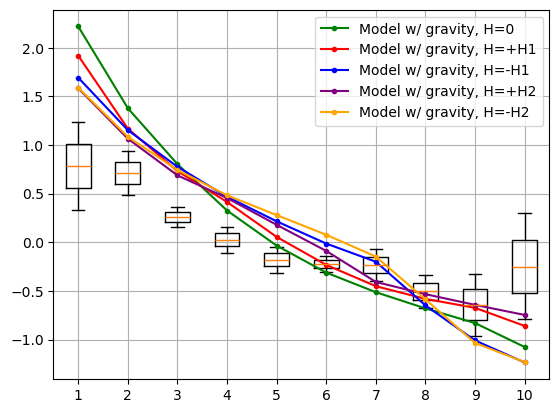

In [20]:
fig, ax = plt.subplots()
data = [[I1["mean"][i], I1["mean+std"][i], I1["mean-std"][i]] for i in range(len(I1["zone"]))]
ax.boxplot(data)
plt.plot(invariants["h=0.0"]["zone"]    , invariants["h=0.0"]["I1^"]    , color="green" , linestyle="-", marker=".", label="Model w/ gravity, H=0"  )
plt.plot(invariants["h=0.005"]["zone"]  , invariants["h=0.005"]["I1^"]  , color="red"   , linestyle="-", marker=".", label="Model w/ gravity, H=+H1")
plt.plot(invariants["h=-0.005"]["zone"] , invariants["h=-0.005"]["I1^"] , color="blue"  , linestyle="-", marker=".", label="Model w/ gravity, H=-H1")
plt.plot(invariants["h=0.0065"]["zone"] , invariants["h=0.0065"]["I1^"] , color="purple", linestyle="-", marker=".", label="Model w/ gravity, H=+H2")
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["I1^"], color="orange", linestyle="-", marker=".", label="Model w/ gravity, H=-H2")
plt.grid()
plt.legend()
plt.show()

### I2

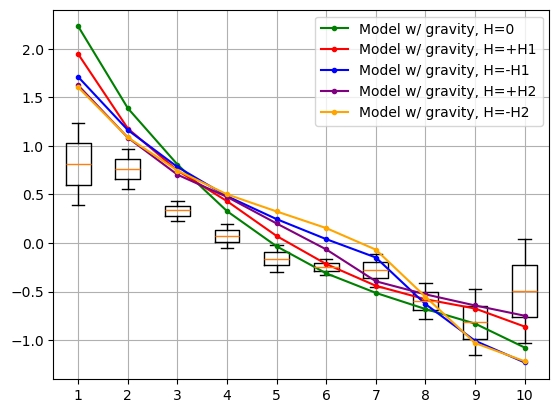

In [21]:
fig, ax = plt.subplots()
data = [[I2["mean"][i], I2["mean+std"][i], I2["mean-std"][i]] for i in range(len(I2["zone"]))]
ax.boxplot(data)
plt.plot(invariants["h=0.0"]["zone"]    , invariants["h=0.0"]["I2^"]    , color="green" , linestyle="-", marker=".", label="Model w/ gravity, H=0"  )
plt.plot(invariants["h=0.005"]["zone"]  , invariants["h=0.005"]["I2^"]  , color="red"   , linestyle="-", marker=".", label="Model w/ gravity, H=+H1")
plt.plot(invariants["h=-0.005"]["zone"] , invariants["h=-0.005"]["I2^"] , color="blue"  , linestyle="-", marker=".", label="Model w/ gravity, H=-H1")
plt.plot(invariants["h=0.0065"]["zone"] , invariants["h=0.0065"]["I2^"] , color="purple", linestyle="-", marker=".", label="Model w/ gravity, H=+H2")
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["I2^"], color="orange", linestyle="-", marker=".", label="Model w/ gravity, H=-H2")
plt.grid()
plt.legend()
plt.show()

### J

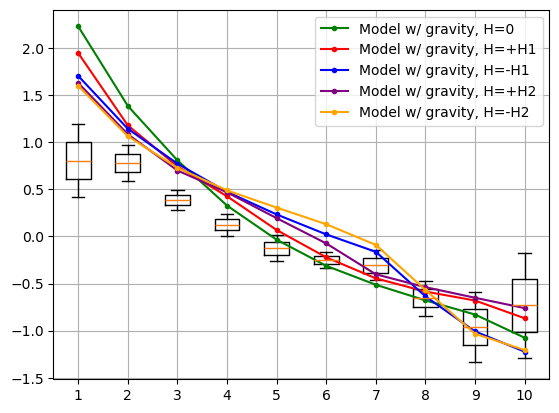

In [22]:
fig, ax = plt.subplots()
data = [[J["mean"][i], J["mean+std"][i], J["mean-std"][i]] for i in range(len(J["zone"]))]
ax.boxplot(data)
plt.plot(invariants["h=0.0"]["zone"]    , invariants["h=0.0"]["J^"]    , color="green" , linestyle="-", marker=".", label="Model w/ gravity, H=0"  )
plt.plot(invariants["h=0.005"]["zone"]  , invariants["h=0.005"]["J^"]  , color="red"   , linestyle="-", marker=".", label="Model w/ gravity, H=+H1")
plt.plot(invariants["h=-0.005"]["zone"] , invariants["h=-0.005"]["J^"] , color="blue"  , linestyle="-", marker=".", label="Model w/ gravity, H=-H1")
plt.plot(invariants["h=0.0065"]["zone"] , invariants["h=0.0065"]["J^"] , color="purple", linestyle="-", marker=".", label="Model w/ gravity, H=+H2")
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["J^"], color="orange", linestyle="-", marker=".", label="Model w/ gravity, H=-H2")
plt.grid()
plt.legend()
plt.show()